In [1]:
import pandas as pd
import re
import string
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words()
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import datetime 


from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
#read in data
df = pd.read_csv('/Users/user/desktop/metis/projects/metis-project-4/data/realdonaldtrump.csv')

## Cleaning ##

In [21]:
#convert date to datetime object
df['date']= pd.to_datetime(df['date'])

In [22]:
#since mentions, hashtags, and links dont have much for us to analyze, lets drop
df=df.drop(['link','mentions','hashtags'], axis=1)

In [23]:
#check for nulls
df.isna().sum()

id           0
content      0
date         0
retweets     0
favorites    0
dtype: int64

In [24]:
#let's peek at the data
df.head()

,id,content,date,retweets,favorites
0,1698308935,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917
1,1701461182,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26
4,1773561338,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945


In [25]:
#im really only interested in trump tweets after he became a political figure, 
#so I'm dropping tweets from before he anncounced his canidacy
mask = (df['date'] > '2015-06-16')
df = df.loc[mask].reset_index(drop=True)

In [27]:
def clean(text):
    #make lowercase, remove links, characters, punctuation, etc.
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    
    # removing the stop-words          
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence
    
    return text

In [28]:
df['clean'] = df['content'].apply(clean)

## Tokenize ##

In [15]:
df['tokens'] =df['clean'].apply(word_tokenize)

## EDA ##

In [31]:
#let's check out the most common words and their counts
common = Counter(" ".join(df["clean"]).split()).most_common(100)
common[:20]

[('great', 3974),
 ('trump', 2093),
 ('thank', 2021),
 ('people', 1872),
 ('realdonaldtrump', 1609),
 ('president', 1399),
 ('us', 1296),
 ('country', 1158),
 ('big', 1146),
 ('new', 1146),
 ('america', 1139),
 ('news', 1120),
 ('get', 1074),
 ('democrats', 1020),
 ('many', 998),
 ('would', 955),
 ('fake', 915),
 ('make', 901),
 ('never', 898),
 ('time', 897)]

In [32]:
#trump tweets "great" almost twice as much as his own name....interesting!

In [34]:
#setting up viz
top_words = [item[0] for item in common]
top_word_counts = [item[1] for item in common]

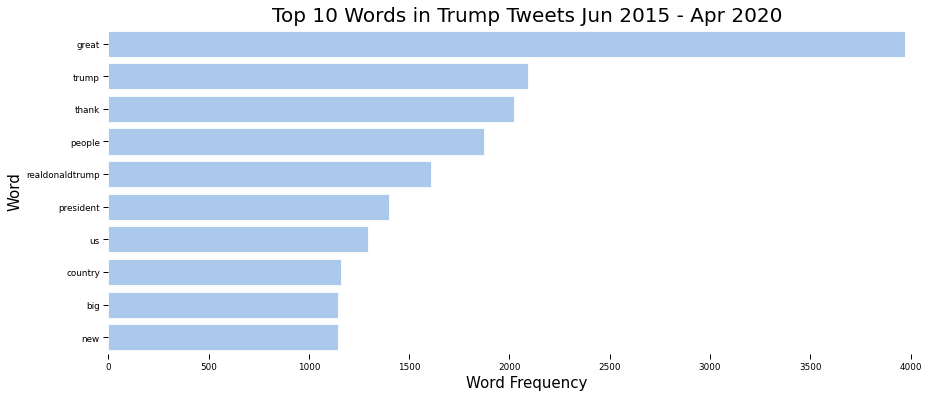

<Figure size 432x288 with 0 Axes>

In [35]:
#quick viz for presentation
sns.set_context('paper')

f, ax = plt.subplots(figsize = (15,6))
sns.set_color_codes('pastel')
sns.barplot(x = top_word_counts[0:10], y = top_words[:10],
            label = '', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
ax.set_xlabel('Word Frequency',fontsize=15)
ax.set_ylabel('Word',fontsize=15)
ax.set_title('Top 10 Words in Trump Tweets Jun 2015 - Apr 2020', fontsize=20)
sns.despine(left = True, bottom = True)
plt.show()
plt.savefig('top_10.png')

## Create Word Vectors with Count-Vectorize ##

In [36]:
count_vectorizer = CountVectorizer(stop_words = 'english')
words_count_vectorize = count_vectorizer.fit_transform(df.clean)
words_count_vectorize

<20074x23924 sparse matrix of type '<class 'numpy.int64'>'
	with 229113 stored elements in Compressed Sparse Row format>

In [37]:
#create new word matrix as df
features = count_vectorizer.get_feature_names()
df_words_count_vec = pd.DataFrame(words_count_vectorize.toarray(), columns=features)
df_words_count_vec

,00,007cigarjoe,007llisav,00patriot,03,05,08,09,0nonsense,10,...,वसन,सक,सच,सद,सन,सपन,सबस,सम,हम,हर
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Also Going to Try TF-IDF ##

In [40]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
words_tfidf = tfidf_vectorizer.fit_transform(df.clean)
words_tfidf

<20074x23924 sparse matrix of type '<class 'numpy.float64'>'
	with 229113 stored elements in Compressed Sparse Row format>

In [41]:
#new new matrix as df
features = tfidf_vectorizer.get_feature_names()
df_words_tfidf = pd.DataFrame(words_tfidf.toarray(), columns=features)
df_words_tfidf

,00,007cigarjoe,007llisav,00patriot,03,05,08,09,0nonsense,10,...,वसन,सक,सच,सद,सन,सपन,सबस,सम,हम,हर
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modeling with NMF on Countvectorizer Word Vectors ##

In [42]:
nmf = NMF(n_components=10, random_state=42)

# fit the transfomed content with NMF
nmf.fit(words_count_vectorize)

# display the result
for index,topic in enumerate(nmf.components_):
    print(f"The top 20 words for topic # {index}")
    print([count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


The top 20 words for topic # 0
['time', 'really', 'tonight', 'senator', 'wonderful', 'fantastic', 'military', 'book', 'country', 'governor', 'night', 'congratulations', 'day', 'today', 'honor', 'state', 'job', 'make', 'america', 'great']


The top 20 words for topic # 1
['second', 'loves', 'need', 'immigration', 'democrats', 'southern', 'borders', 'amendment', 'complete', 'vets', 'vote', 'total', 'endorsement', 'security', 'country', 'crime', 'military', 'strong', 'wall', 'border']


The top 20 words for topic # 2
['bush', 'election', 'lead', 'hes', 'carson', 'vote', 'true', 'rubio', 'cruz', 'administration', 'tower', 'cnn', '2016', 'gop', 'foxnews', 'campaign', 'mr', 'poll', 'donald', 'trump']


The top 20 words for topic # 3
['white', 'house', 'totally', 'dont', 'sources', 'stories', 'russia', 'dishonest', 'reporting', 'ratings', 'said', 'like', 'good', 'bad', 'corrupt', 'story', 'cnn', 'media', 'fake', 'news']


The top 20 words for topic # 4
['rating', 'approval', 'american', 'hono

## Topic Modeling with NMF on TF-IDF Vectors ##

In [47]:
nmf = NMF(n_components=10, random_state=42)

# fit the transfomed content with NMF
nmf.fit(words_tfidf)

# display the result
for index,topic in enumerate(nmf.components_):
    print(f"The top 20 words for topic # {index}")
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


The top 20 words for topic # 0
['jobs', 'business', 'votetrump', 'order', 'united', 'imwithyou', 'realdonaldtrump', 'deal', 'americafirst', 'vote', 'need', 'needs', 'crippled', 'making', 'going', 'lets', 'safe', 'great', 'make', 'america']


The top 20 words for topic # 1
['carolina', 'iowa', '95', 'pennsylvania', 'mike', 'poll', 'trump2016', 'ohio', 'party', 'working', 'florida', 'words', 'republican', 'approval', 'rating', 'honor', 'support', 'love', 'nice', 'thank']


The top 20 words for topic # 2
['republicans', 'vote', 'china', 'years', 'republican', 'american', 'military', 'strong', 'security', 'dont', 'crime', 'united', 'states', 'time', 'president', 'wall', 'country', 'democrats', 'border', 'people']


The top 20 words for topic # 3
['interview', 'best', 'need', 'megynkelly', 'poll', 'like', 'debate', 'love', 'gop', '2016', 'foxnews', 'vote', 'true', 'cnn', 'thanks', 'mr', 'president', 'donald', 'realdonaldtrump', 'trump']


The top 20 words for topic # 4
['sources', 'conferen

## Topic Modeling w LDA on Count Vectorizer Word Vecs ##

In [45]:
LDA = LatentDirichletAllocation(n_components = 10, n_jobs = -2, random_state = 42)

# fit the transfomed content with LDA
LDA.fit(words_count_vectorize)

# display the result
for index,topic in enumerate(LDA.components_):
    print(f"The top 20 words for topic # {index}")
    print([count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

The top 20 words for topic # 0
['japan', 'replace', 'soon', 'whitehouse', 'rating', 'healthcare', 'approval', 'thank', 'looking', 'prime', 'meeting', 'american', 'minister', 'obamacare', 'party', 'look', 'today', 'republican', 'great', 'forward']


The top 20 words for topic # 1
['like', 'wow', 'american', 'time', 'ted', 'going', 'president', 'good', 'people', 'way', 'cruz', 'pelosi', 'nancy', 'white', 'trump2016', 'new', 'trump', 'realdonaldtrump', 'house', 'thank']


The top 20 words for topic # 2
['work', 'obama', 'good', 'illegal', 'united', 'iran', 'like', 'bad', 'states', 'dont', 'immigration', 'president', 'great', 'security', 'hillary', 'wall', 'country', 'democrats', 'border', 'people']


The top 20 words for topic # 3
['report', 'time', 'bad', 'story', 'fbi', 'crooked', 'clinton', 'russia', 'collusion', 'said', 'hunt', 'witch', 'people', 'hillary', 'democrats', 'president', 'trump', 'media', 'fake', 'news']


The top 20 words for topic # 4
['rubio', 'live', 'night', 'pm', 'in

## Topic Modeling w LDA on TF-IDF Word Vectors  ##

In [48]:
LDA = LatentDirichletAllocation(n_components = 10, n_jobs = -2, random_state = 42)

# fit the transfomed content with LDA
LDA.fit(words_tfidf)

# display the result
for index,topic in enumerate(LDA.components_):
    print(f"The top 20 words for topic # {index}")
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

The top 20 words for topic # 0
['vpdebate', 'bruce', 'ohr', 'donald', 'jimmyfallon', 'makeamericagreatagain', 'disgraceful', 'look', 'india', 'american', 'today', 'abe', 'trump', 'forward', 'japan', 'great', 'realdonaldtrump', 'minister', 'prime', 'thank']


The top 20 words for topic # 1
['foxnews', 'people', 'pm', 'love', 'mark', 'today', 'white', 'house', 'read', 'oil', 'conference', 'new', 'wow', 'book', 'trump', 'great', 'realdonaldtrump', 'makeamericagreatagain', 'trump2016', 'thank']


The top 20 words for topic # 2
['united', 'republican', 'immigration', 'good', 'vote', 'time', 'dont', 'job', 'strong', 'crime', 'military', 'president', 'security', 'big', 'wall', 'democrats', 'country', 'people', 'border', 'great']


The top 20 words for topic # 3
['bad', 'campaign', 'said', 'mueller', 'story', 'clinton', 'fbi', 'russia', 'crooked', 'people', 'collusion', 'democrats', 'trump', 'president', 'hillary', 'witch', 'hunt', 'media', 'news', 'fake']


The top 20 words for topic # 4
['en

## NMF on Count vectorizer seems to give more interesting AND intuitive results ##
### Let's proceed with this for some further analysis ###

In [49]:
#create new df of word weights for each topic/component
topic_words = pd.DataFrame(nmf.components_.round(10),
             index = ["component_1","component_2",
                     "component_3","component_4",
                     "component_5","component_6",
                     "component_7","component_8",
                    "component_9","component_10"],
             columns = tfidf_vectorizer.get_feature_names())
topic_words

,00,007cigarjoe,007llisav,00patriot,03,05,08,09,0nonsense,10,...,वसन,सक,सच,सद,सन,सपन,सबस,सम,हम,हर
component_1,0.000000,0.000000,0.004421,0.000000,0.000000,0.000798,0.000000,0.000000,0.000000,0.001328,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_2,0.000000,0.000000,0.000000,0.001223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000891,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000425,0.000000,0.000000,0.000000,0.022080,...,7.500000e-09,7.500000e-09,9.506000e-07,7.500000e-09,9.506000e-07,3.400000e-09,4.700000e-09,9.161000e-07,9.062000e-07,9.506000e-07
component_4,0.001278,0.001220,0.011393,0.001538,0.000000,0.000000,0.000000,0.000000,0.001761,0.019162,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_5,0.000291,0.000000,0.000494,0.000000,0.000844,0.000000,0.000000,0.003162,0.000000,0.009473,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_7,0.000000,0.017183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_8,0.000077,0.000000,0.000000,0.000000,0.000072,0.000000,0.000069,0.002675,0.000000,0.050754,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003038,0.000000,0.000000,0.001890,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_10,0.000000,0.000000,0.000000,0.000000,0.003760,0.000011,0.000032,0.001961,0.000014,0.014913,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [ ]:
#looks like I could've done a better job cleaning, but I got useful, interesting topics!

In [50]:
model = nmf.fit(words_count_vectorize)
doc_topics = model.transform(words_count_vectorize)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [52]:
#greate df showing topic weights for each tweet
component_df = pd.DataFrame(doc_topics.round(10),
             index = [i for i in df.index],
             columns = ["component_1","component_2",
                     "component_3","component_4",
                     "component_5","component_6",
                     "component_7","component_8",
                    "component_9","component_10"])

component_df

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,0.119420,0.000000,0.000000,0.000000,0.005877,0.000000,0.000721,0.185750,0.016622,0.00000
1,0.106854,0.000000,0.000000,0.105906,0.000000,0.000000,0.003980,0.157989,0.005187,0.00000
2,0.011351,0.000000,0.000000,0.001292,0.011741,0.000909,0.000000,0.179243,0.016186,0.01896
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003454,0.144971,0.000805,0.00000
4,0.189296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157084,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
20069,0.000000,0.022537,0.000321,0.002355,0.000000,0.002853,0.003870,0.000000,0.000108,0.00668
20070,0.002553,0.000000,0.000356,0.001814,0.004002,0.000000,0.000000,0.005541,0.012479,0.00000
20071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
20072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [53]:
#rename components with topic names
component_df.rename(columns={"component_1": "Patriotism_1",
                            "component_2": "Crime_Security",
                            "component_3": "GOP",
                            "component_4": "Fake_News",
                            "component_5": "Election",
                            "component_6": "Self_Congratulatory_unclear",
                            "component_7": "Fopo",
                            "component_8": "Unclear",
                            "component_9": "Economy",
                            "component_10": "Democrats_Conspiracy",
                            })

,Patriotism_1,Crime_Security,GOP,Fake_News,Election,Self_Congratulatory_unclear,Fopo,Unclear,Economy,Democrats_Conspiracy
0,0.119420,0.000000,0.000000,0.000000,0.005877,0.000000,0.000721,0.185750,0.016622,0.00000
1,0.106854,0.000000,0.000000,0.105906,0.000000,0.000000,0.003980,0.157989,0.005187,0.00000
2,0.011351,0.000000,0.000000,0.001292,0.011741,0.000909,0.000000,0.179243,0.016186,0.01896
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003454,0.144971,0.000805,0.00000
4,0.189296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157084,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
20069,0.000000,0.022537,0.000321,0.002355,0.000000,0.002853,0.003870,0.000000,0.000108,0.00668
20070,0.002553,0.000000,0.000356,0.001814,0.004002,0.000000,0.000000,0.005541,0.012479,0.00000
20071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
20072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [54]:
#bring in date for plotting
component_df['datetime'] = df['date']
component_df.reset_index(drop=True)
component_df = component_df[['datetime'] + [col for col in component_df.columns if col != 'datetime']]
component_df

,datetime,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,2015-06-16 02:04:03,0.119420,0.000000,0.000000,0.000000,0.005877,0.000000,0.000721,0.185750,0.016622,0.00000
1,2015-06-16 02:04:19,0.106854,0.000000,0.000000,0.105906,0.000000,0.000000,0.003980,0.157989,0.005187,0.00000
2,2015-06-16 02:28:37,0.011351,0.000000,0.000000,0.001292,0.011741,0.000909,0.000000,0.179243,0.016186,0.01896
3,2015-06-16 02:28:54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003454,0.144971,0.000805,0.00000
4,2015-06-16 02:29:11,0.189296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157084,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...
20069,2020-06-17 19:00:32,0.000000,0.022537,0.000321,0.002355,0.000000,0.002853,0.003870,0.000000,0.000108,0.00668
20070,2020-06-17 19:11:47,0.002553,0.000000,0.000356,0.001814,0.004002,0.000000,0.000000,0.005541,0.012479,0.00000
20071,2020-06-17 21:27:33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
20072,2020-06-17 21:28:38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [55]:
#setting up a groupby to look at some greater trends in topic strength over his presidency
#and in repsonse to specific events
component_df['month'] = component_df['datetime'].apply(lambda t: t.month)
component_df['year'] = component_df['datetime'].apply(lambda t: t.year)

<ipython-input-55-255eefdba5f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  component_df['month'] = component_df['datetime'].apply(lambda t: t.month)
<ipython-input-55-255eefdba5f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  component_df['year'] = component_df['datetime'].apply(lambda t: t.year)


In [56]:
#topic names
component_df_new = component_df.rename(columns={"component_1": "Patriotism_1",
                            "component_2": "Crime_Security",
                            "component_3": "GOP",
                            "component_4": "Fake_News",
                            "component_5": "Election",
                            "component_6": "Self_Congratulatory_unclear",
                            "component_7": "Fopo",
                            "component_8": "Unclear",
                            "component_9": "Economy",
                            "component_10": "Democrats_Conspiracy",
                            })

In [57]:
#to csv for working in Tableau
component_df_new.to_csv(r'/Users/user/desktop/Metis/projects/metis-project-4/all_tweets_w_topics.csv', index = False, header=True)

In [59]:
# I wanted to locate locate maximum / "model" tweets for each topic, so I brought back his original tweets
component_df_new["tweet"] = df["content"]

In [60]:
#and now lets look at the maximum tweets for rach topic

for topic in component_df_new.columns.values[1:11]:
    print(topic)
    print(component_df_new[component_df_new[topic] == component_df_new[topic].max()]["tweet"].values[0] + "\n")

Patriotism_1
I am hearing so many great things about the Republican Party’s California Gubernatorial Candidate, John Cox. He is a very successful businessman who is tired of high Taxes & Crime. He will Make California Great Again & make you proud of your Great State again. Total Endorsement!

Crime_Security
Thank you to Congressman Kevin Yoder! He secured $5 BILLION for Border Security. Now we need Congress to support. Kevin has been strong on Crime, the Border, the 2nd Amendment, and he loves our Military and Vets. @RepKevinYoder has my full and total endorsement!

GOP
“Barack Obama talked a lot about hope, but Donald Trump delivered the American Dream. All the economic indicators, what’s happening overseas, Donald Trump has proven to be far more successful than Barack Obama. President Trump is delivering the American Dream.” Jason Chaffetz

Fake_News
Google search results for “Trump News” shows only the viewing/reporting of Fake News Media. In other words, they have it RIGGED, for me

In [61]:
#some pretty interesting stuff here, and others that don't really make too much sense (Election)
#may want to revisit

In [74]:
#group by for plotting
components_monthly = component_df_new.groupby(['year', 'month'])["Patriotism_1", "Crime_Security", "GOP",
                                                                "Fake_News", "Election", 
                                                                 "Self_Congratulatory_unclear", "Fopo",
                                                                 "Unclear", "Economy","Democrats_Conspiracy"].mean()

components_monthly = components_monthly.reset_index(level=0, inplace=False)

<ipython-input-74-562f989be37a>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  components_monthly = component_df_new.groupby(['year', 'month'])["Patriotism_1", "Crime_Security", "GOP",


In [80]:
components_monthly.reset_index(inplace=True)

In [81]:
#move date columns over
components_monthly['DATE'] = pd.to_datetime(components_monthly[['year', 'month']].assign(DAY=1))
components_monthly = components_monthly[['DATE'] + [col for col in components_monthly.columns if col != 'DATE']]

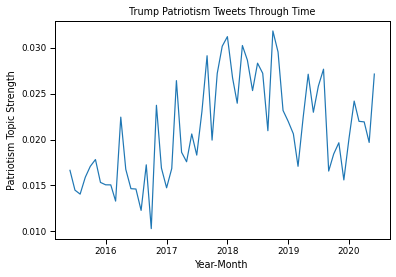

In [82]:
plt.plot(components_monthly['DATE'], components_monthly['Patriotism_1'])
plt.title('Trump Patriotism Tweets Through Time')
plt.xlabel('Year-Month')
plt.ylabel('Patriotism Topic Strength')
plt.show()

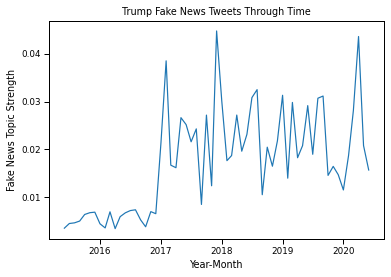

In [84]:
plt.plot(components_monthly['DATE'], components_monthly['Fake_News'])
plt.title('Trump Fake News Tweets Through Time')
plt.xlabel('Year-Month')
plt.ylabel('Fake News Topic Strength')
plt.show()

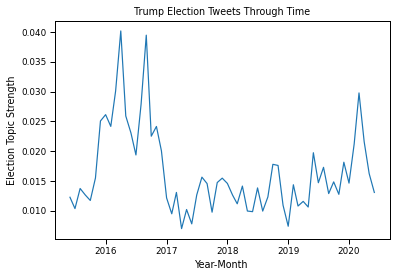

In [86]:
plt.plot(components_monthly['DATE'], components_monthly['Election'])
plt.title('Trump Election Tweets Through Time')
plt.xlabel('Year-Month')
plt.ylabel('Election Topic Strength')
plt.show()

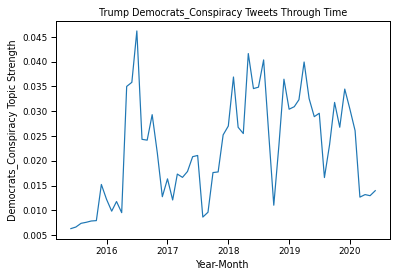

In [87]:
plt.plot(components_monthly['DATE'], components_monthly['Democrats_Conspiracy'])
plt.title('Trump Democrats_Conspiracy Tweets Through Time')
plt.xlabel('Year-Month')
plt.ylabel('Democrats_Conspiracy Topic Strength')
plt.show()

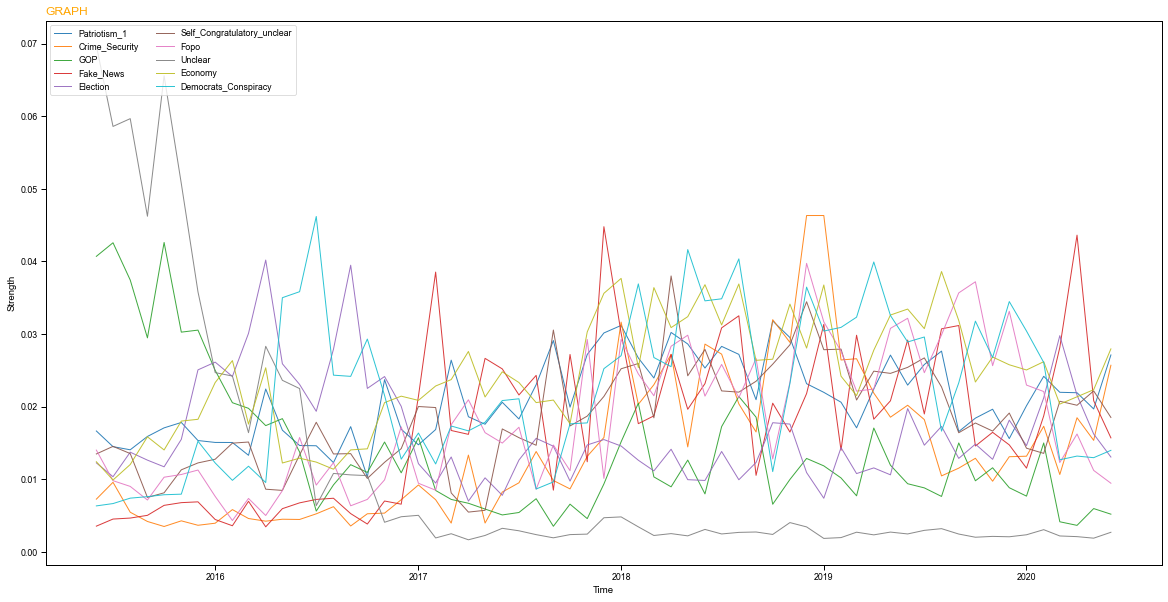

In [89]:
# making the worst graph possible for a bad viz competition
num=0
plt.figure(figsize=(20,10)) 
for column in components_monthly.drop(['DATE', 'month', 'year'], axis=1):
    num+=1
    plt.plot(components_monthly['DATE'], components_monthly[column], marker='', linewidth=1, alpha=0.9, label=column)

    # Add legend
    plt.legend(loc=2, ncol=2)

    # Add titles
    plt.title("GRAPH", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Time")
    plt.ylabel("Strength")

sns.set_style("whitegrid", {'axes.grid' : False})
plt.savefig('trump_topics_bad.jpg')


In [137]:
#for plotting in tableau
comp_df.to_csv(r'/Users/user/desktop/Metis/projects/metis-project-4/monthly_topics.csv', index = False, header=True)

In [ ]:
## looking for tweets in the peaks of Fake News over time##

In [91]:
#based on tableau chart, I wanted to revisit some specific dates in which trump seemed to tweet the most about Fake News
#so, I honed in on these days to get an idea of what he was tweeting about
df[df['date'].dt.strftime('%Y-%m-%d') == '2019-09-15']

,id,content,date,retweets,favorites,clean
15950,1173209179886096384,Thank you Billy!https://twitter.com/USRepLong/...,2019-09-15 07:17:20,8393,39451,thank billy
15951,1173210997303193600,All based on NOTHING! The Dems can’t get anyth...,2019-09-15 07:24:33,12174,45812,based nothing dems cant get anything positive ...
15952,1173216300287635456,Now the Radical Left Democrats and their Partn...,2019-09-15 07:45:37,18325,73056,radical left democrats partner lamestream medi...
15953,1173226232688926721,Thank you @ foxandfriends and @ RepMarkMeadows...,2019-09-15 08:25:06,5887,31231,thank foxandfriends repmarkmeadows great inter...
15954,1173231877181857795,Brett Kavanaugh should start suing people for ...,2019-09-15 08:47:31,28929,113128,brett kavanaugh start suing people libel justi...
15955,1173297587773947920,Can’t let Brett Kavanaugh give Radical Left De...,2019-09-15 13:08:38,18256,64444,cant let brett kavanaugh give radical left dem...
15956,1173300571379503104,"I am fighting the Fake (Corrupt) News, the Dee...",2019-09-15 13:20:29,23455,94391,fighting fake corrupt news deep state democrat...
15957,1173305965019566085,Can’t believe the @ washingtonpost wrote a pos...,2019-09-15 13:41:55,12262,52150,cant believe washingtonpost wrote positive fro...
15958,1173307978591739904,"....Then, on top of it all, Kathleen Parker, o...",2019-09-15 13:49:55,9123,42856,top kathleen parker people wrote case wonderin...
15959,1173354644636127232,"Based on the attack on Saudi Arabia, which may...",2019-09-15 16:55:21,18562,79789,based attack saudi arabia may impact oil price...


In [92]:
df[df['date'].dt.strftime('%Y-%m-%d') == '2018-08-12']["content"].values

array(['. @ JudgeJeanine “Bob Mueller, isn’t your whole investigation premised on a Fake Dossier, paid for by Hillary, created by a man who hates Donald Trump, & used to con a FISA Court Judge. Bob, I really think it’s time for you to give up your phony investigation.” No Collusion!',
       '. @ GovMikeHuckabee “Your paycheck is bigger, your pension is stronger.” @ foxandfriends Unemployment numbers are better than they have been in 50 years, & perhaps ever. Our country is booming like never before - and it will get even better! Many companies moving back to the U.S.A.',
       'Many @ harleydavidson owners plan to boycott the company if manufacturing moves overseas. Great! Most other companies are coming in our direction, including Harley competitors. A really bad move! U.S. will soon have a level playing field, or better.',
       '“Seems like the Department of Justice (and FBI) had a program to keep Donald Trump from becoming President”. @ DarrellIssa @ foxandfriends If this had ha

In [95]:
df[df['date'].dt.strftime('%Y-%m-%d') == '2019-09-15']["content"].values

array(['Thank you Billy!https://twitter.com/USRepLong/status/1172515960336654336 …',
       'All based on NOTHING! The Dems can’t get anything positive done, and probably don’t want to.https://twitter.com/SteveScalise/status/1172911375783534594 …',
       'Now the Radical Left Democrats and their Partner, the LameStream Media, are after Brett Kavanaugh again, talking loudly of their favorite word, impeachment. He is an innocent man who has been treated HORRIBLY. Such lies about him. They want to scare him into turning Liberal!',
       'Thank you @ foxandfriends and @ RepMarkMeadows. Great interview!',
       'Brett Kavanaugh should start suing people for libel, or the Justice Department should come to his rescue. The lies being told about him are unbelievable. False Accusations without recrimination. When does it stop? They are trying to influence his opinions. Can’t let that happen!',
       'Can’t let Brett Kavanaugh give Radical Left Democrat (Liberal Plus) Opinions based on threat

In [96]:
df[df['date'].dt.strftime('%Y-%m-%d') == '2020-04-19']["content"].values

array(['Look forward to this!https://twitter.com/realDonaldTrump/status/1251657119595626502 …',
       'Great credit must be given to @ FEMA and all of those that are helping our States make it big!https://twitter.com/FEMA_Pete/status/1251587849973108740 …',
       'Just like I was right on Ventilators (our Country is now the “King of Ventilators”, other countries are calling asking for help-we will!), I am right on testing. Governors must be able to step up and get the job done. We will be with you ALL THE WAY!',
       'Nervous Nancy is an inherently “dumb” person. She wasted all of her time on the Impeachment Hoax. She will be overthrown, either by inside or out, just like her last time as “Speaker”. Wallace & @ FoxNews are on a bad path, watch!https://twitter.com/GOP/status/1251827905459556352 …',
       '. @ FoxNews “Dems say President Trump is trying to open the United States Economy too quickly”, but, if I took even a little more time, they would loudly chant that I am moving to